# Assessment of Cosmic Ray Zenith Estimation

## Import Required Modules

In [1]:
%matplotlib inline

import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from utils import get_cuts, get_event_parameters, get_training_assessment_cut, r_log

## Model and Assessment Selection

In [2]:
### The keys will be the names of the models you wish to analyze.
# The values will be the nuclei to assess for each model.
MODEL_NAMES_AND_NUCLEI = {
    'zenith_baseline': 'phof'
}

In [3]:
# IceTop-CNN folder in /data/user
ICETOP_CNN_DATA_DIR = os.getenv('ICETOP_CNN_DATA_DIR')
# Folder containing the models
MODELS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'models')
# Folder containing the reconstructions
RECONSTRUCTIONS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'reconstructions', 'zenith')
# Folder containing the simulation data.
SIMDATA_FOLDER_PATH = os.path.join(os.sep, 'data', 'user', 'fmcnally', 'icetop-cnn', 'simdata')

# Various potential error messages.
ERROR_MODELS_FOLDER_PATH_NOT_FOUND = 'Could not find models folder. Path specified: '
ERROR_NO_MODELS_SELECTED = 'No models selected for analysis!'

### List Available Models

In [4]:
# Ensure that the models folder has been found.
assert os.path.exists(MODELS_FOLDER_PATH), f'{ERROR_MODELS_FOLDER_PATH_NOT_FOUND}{MODELS_FOLDER_PATH}'

# Get all model reconstructions .npy files.
model_list = glob(os.path.join(RECONSTRUCTIONS_FOLDER_PATH, '*.npy'))
# Trim parent directories and file extension for each.
model_list = [os.path.splitext(os.path.basename(model))[0] for model in model_list]

# Get all model parameters .json files.
param_list = glob(os.path.join(MODELS_FOLDER_PATH, '*', '*.json'))
# Trim parent directories and file extension for each.
param_list = [os.path.splitext(os.path.basename(param))[0] for param in param_list]

# Print models that have both .npy and .json files.
print(f'Available models: {sorted(set(model_list).intersection(param_list))}')
# Print models that have a .npy file but no .json file.
print(f'Models without parameter files: {sorted(set(model_list).difference(param_list))}')

Available models: ['cos_test', 'zenith_baseline', 'zenith_test']
Models without parameter files: []


### Load Model Parameters

In [5]:
# Create a dictionary to store model parameters.
model_parameters = {}
# Loop over model names and their corresponding assessment nuclei.
for model_name, assessment_nuclei in MODEL_NAMES_AND_NUCLEI.items():
    
    # Construct the full .json model path.
    model_path = os.path.join(MODELS_FOLDER_PATH, model_name, model_name + '.json')

    # Ensure that the model is found (no typos).
    if not os.path.exists(model_path):
        print(f'WARNING: Model {model_name} not found at {MODELS_FOLDER_PATH}')
        continue

    # Load model parameters and save into the dictionary.
    with open(model_path, 'r') as f:
        model_parameters[model_name] = json.load(f)
    # Add assessment nuclei to model parameters. Sort the composition string into a predictable order.
    model_parameters[model_name].update(
        {'assessment_nuclei': ''.join(sorted(assessment_nuclei, key=lambda c: list('phof').index(c)))})
    
    # Print an entry for each model.
    print(f'{model_name:>{max(map(len, MODEL_NAMES_AND_NUCLEI))}} : {model_parameters[model_name]}')

# Ensure that at least one valid model has been selected for assessment.
assert len(model_parameters), ERROR_NO_MODELS_SELECTED

zenith_baseline : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 'q_clip': False, 't_clip': False, 'normed': True, 'reco': None, 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}


## Prepare Reconstructions

### Load Event Parameters

This might takes a few seconds.

In [6]:
# We must always load all nuclei. Each model will have a unique preference for which events to assess on.
# Undesired events are cut next.
event_parameters = get_event_parameters(SIMDATA_FOLDER_PATH, composition='phof')
event_parameters['zenith'] = np.array([direction[0] for direction in event_parameters['dir']])

### Load Model Reconstructions and Generate Cuts

In [7]:
# Map the nuclei string representations to their atomic weights.
comp_conversion = {'p':1, 'h':4, 'o':16, 'f':56}

# Build dictionaries for model reconstructions and events cuts.
reconstructions, cuts = {}, {}
# Loop over model names and their corresponding parameters.
for model_name, model_prep in model_parameters.items():

    # Load model predictions. It is important to flatten the predictions into a one-dimensional array.
    reconstruction = np.load(os.path.join(RECONSTRUCTIONS_FOLDER_PATH, model_name + '.npy')).flatten()
    
    # Get the model-specific assessment cut.
    model_cut = get_training_assessment_cut(event_parameters, 'assessment', model_prep)

    # Get the list of atomic weights for the desired nuclei.
    nuclei_to_assess = [comp_conversion[nuclei] for nuclei in model_prep['assessment_nuclei']]

    # Apply the nuclei cut to the model predictions.
    reconstruction = reconstruction[np.isin(event_parameters['comp'][model_cut], nuclei_to_assess)]
    # Save the model predictions.
    reconstructions[model_name] = reconstruction
    # Get the model-specific events cut.
    model_cut = np.isin(event_parameters['comp'], nuclei_to_assess) * model_cut
    # Save the model-specific events cut.
    cuts[model_name] = model_cut

## Assess Models

### Summary Statistics

In [8]:
# CONFIG FOR STATS
log_difference, reco_percent = 0.03490658504, 10
cut_names = ['Uncut', 'Quality']

# Loop over each model's name and their corresponding reconstructed zeniths.
for model_name, reconstructed_zenith in reconstructions.items():
    # Print a header entry for each model.
    print(f'Stats for {model_name}:')

    # Loop over the cuts.
    for cut_name in cut_names:
        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)

        # Calculate the event-wise difference in reconstructed vs true logged zeniths.
        diff = reconstructed_zenith[reconstructions_cut] - event_parameters['zenith'][events_cut]
        # Calculate the event-wise difference in reconstructed vs true unlogged zeniths.
        true_diff = r_log(reconstructed_zenith[reconstructions_cut]) - r_log(event_parameters['zenith'][events_cut])
        # Calculate the event-wise percent difference in reconstructed vs true unlogged zeniths.
        percent_diff = 100 * true_diff / r_log(event_parameters['zenith'][events_cut])

        # Calculate zenith resolution statistics for the logged zenith difference.
        std_dev_lo, median, std_dev_hi = np.percentile(diff, (16,50,84))

        # Calculate the percentage of events whose difference in true and reconstructed zeniths is less than "log_difference".
        diff_percentage = 100 * len(list(filter(lambda x: abs(x) <= log_difference, diff))) / len(diff)
        # Calculate the percentage of events whose reconstructed zeniths are within "reco_percent"% of their true zeniths.
        percent_diff_percentage = 100 * len(list(filter(lambda x: abs(x) <= reco_percent, percent_diff))) / len(percent_diff)

        # Print the summary statistics.
        print(f'{" "*2}{cut_name}')
        print(f'{" "*4}Zenith resolution: {median*180/np.pi:.3f} +{std_dev_hi*180/np.pi:.3f} {std_dev_lo*180/np.pi:.3f}')
        print(f'{" "*4}Events reconstructed within a {log_difference*180/np.pi:.2f} degree difference in order of magnitude: {diff_percentage:.2f}%')
        print(f'{" "*4}Events reconstructed within {reco_percent}% of their true zeniths: {percent_diff_percentage:.2f}%')
    
    print() # Newline for readability


Stats for zenith_baseline:
  Uncut
    Zenith resolution: -0.118 +2.080 -2.091
    Events reconstructed within a 2.00 degree difference in order of magnitude: 66.16%
    Events reconstructed within 10% of their true zeniths: 75.39%
  Quality
    Zenith resolution: -0.416 +1.011 -1.861
    Events reconstructed within a 2.00 degree difference in order of magnitude: 80.63%
    Events reconstructed within 10% of their true zeniths: 89.10%



### Logged Zenith Resolution

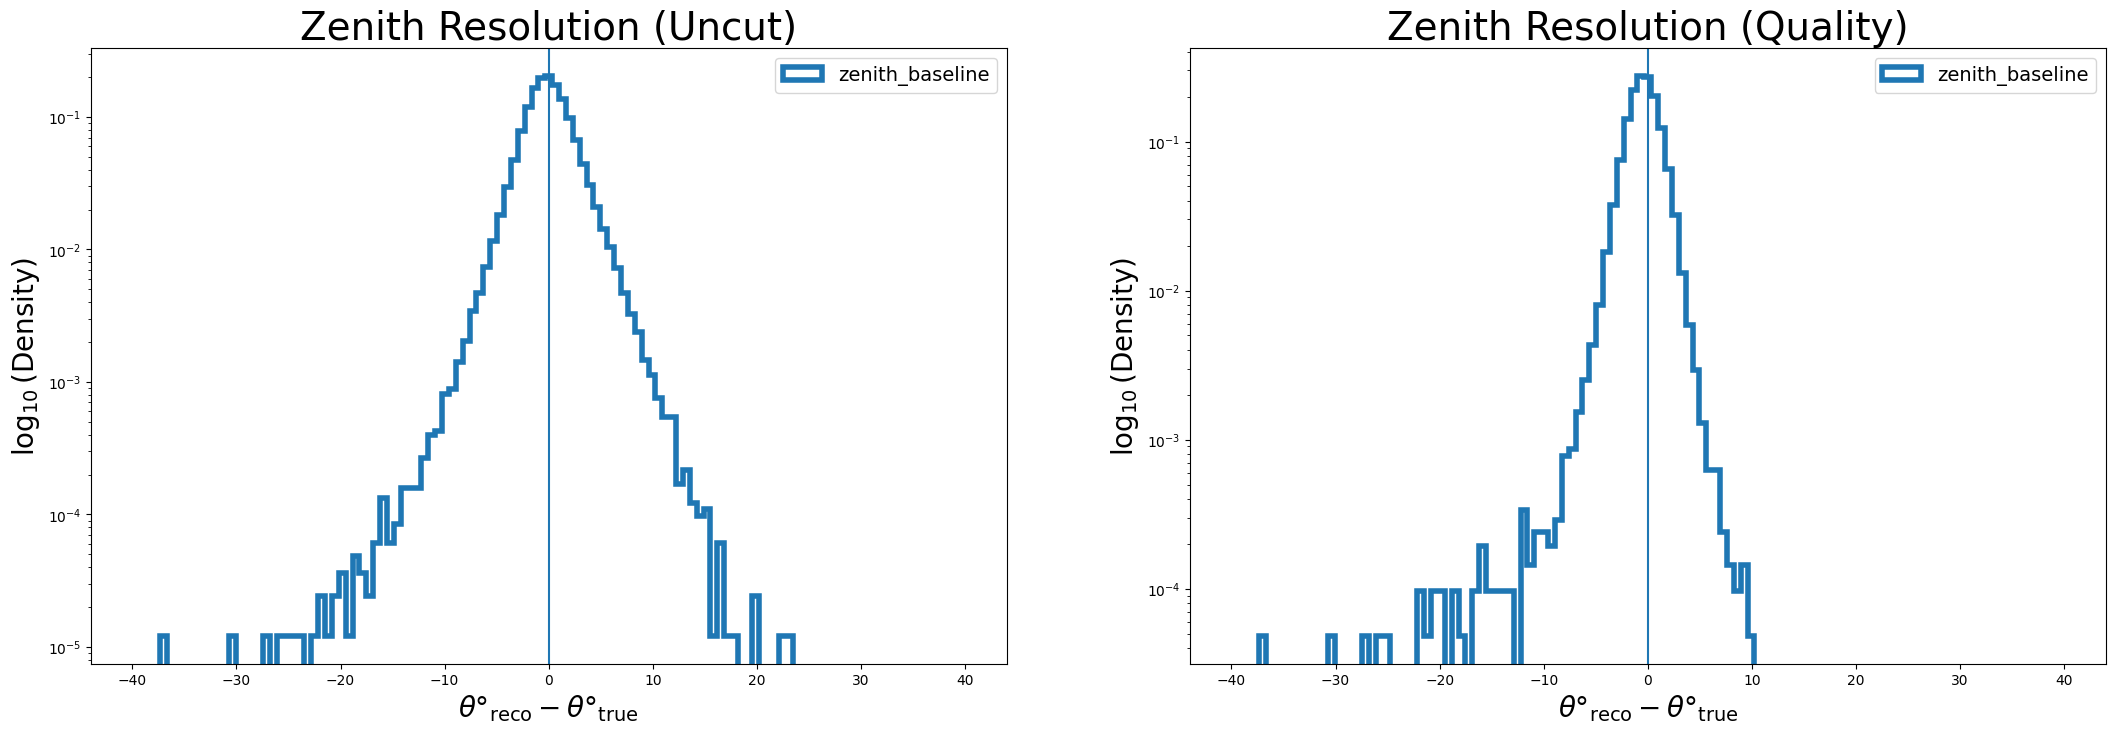

In [9]:
# CONFIG FOR PLOT
cut_names = ['Uncut', 'Quality']
hist_args = {'range':(-40,40), 'bins':121, 'density':True, 'histtype':'step', 'log':True, 'linewidth':4}

# CONFIG FOR TEXT
title_params = {'fontsize':28}
label_params = {'fontsize':20}
legend_params = {'fontsize':14}

# VARIABLES FOR PLOT
ncols = len(cut_names)

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

# If we are assessing only one cut, add an artificial dimension.
if ncols == 1: axs = np.array([axs])
# Loop over the cuts.
for ax, cut_name in zip(axs, cut_names):
    # Loop over the models.
    for model_name in model_parameters:
        
        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        
        # Plot the logged difference histogram.
        ax.hist((180/np.pi*reconstructions[model_name][reconstructions_cut] - 180/np.pi*event_parameters['zenith'][events_cut]),
                label=model_name, **hist_args)

    # Plot a vertical line through the center of each plot.
    # This line designates the ideal reconstruction.
    ax.axvline()

    # Decorate the plot.
    ax.set_title(f'Zenith Resolution ({cut_name})', **title_params)
    ax.set_xlabel(r'$θ\degree_{\mathrm{reco}} - θ\degree_{\mathrm{true}}$', **label_params)
    ax.set_ylabel(r'$\log_{10}$(Density)', **label_params)
    ax.legend(**legend_params)

### Unlogged Zenith Resolution

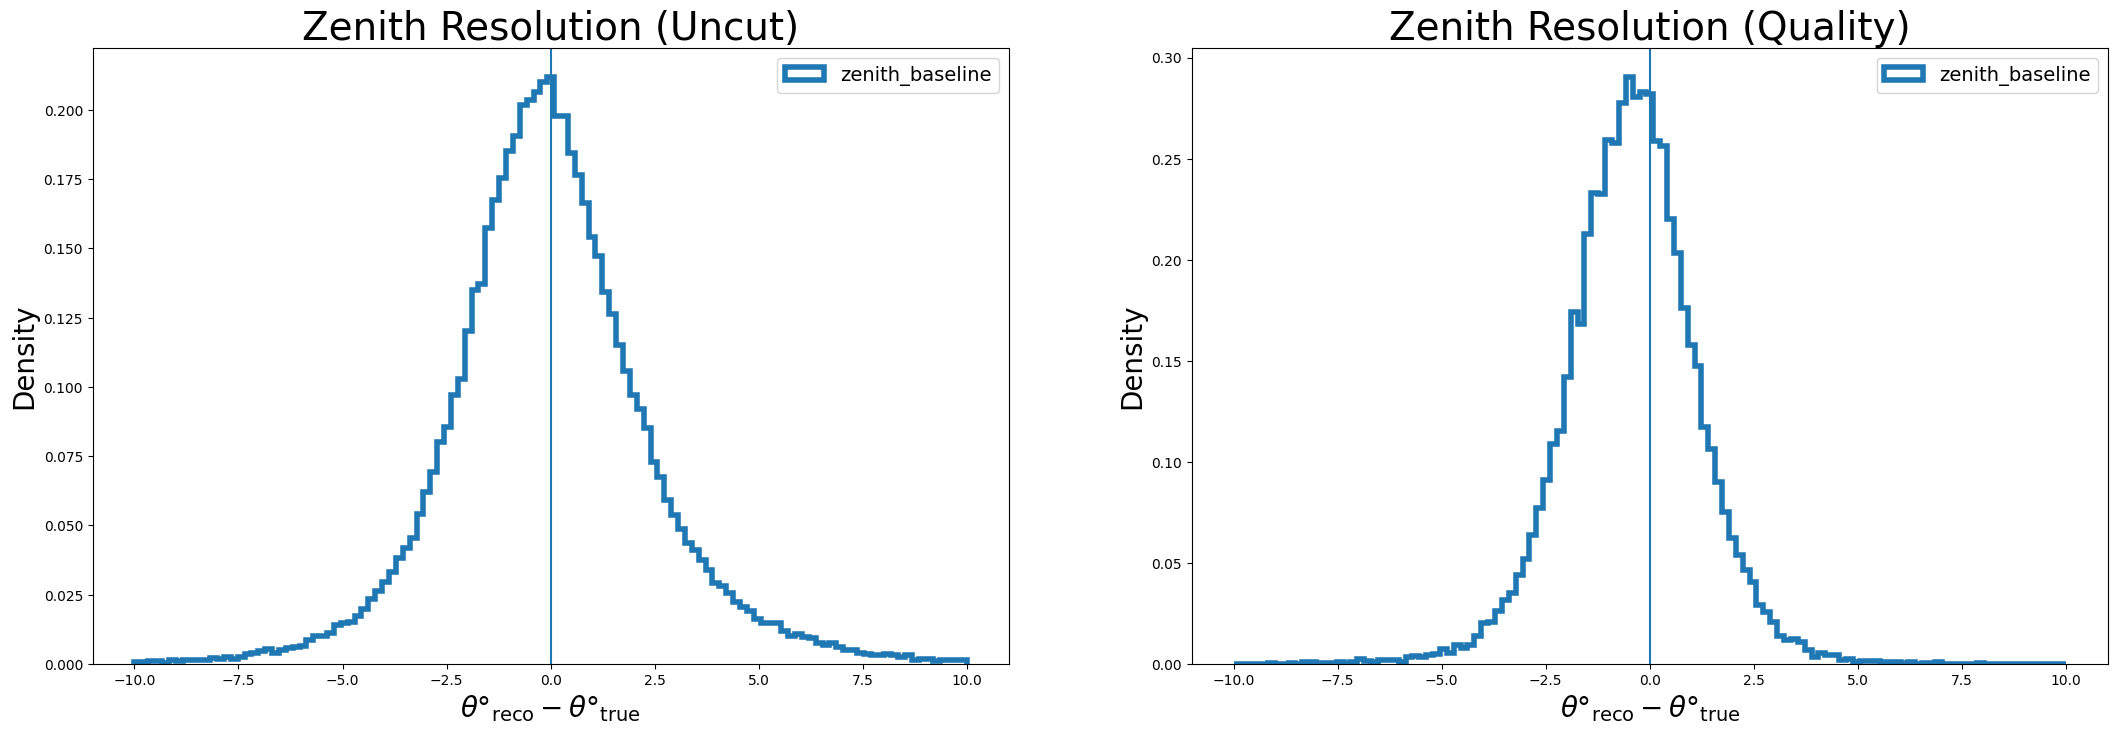

In [10]:
# CONFIG FOR PLOT
cut_names = ['Uncut', 'Quality']
hist_args = {'range':(-10,10), 'bins':121, 'density':True, 'histtype':'step', 'log':False, 'linewidth':4}

# CONFIG FOR TEXT
title_params = {'fontsize':28}
label_params = {'fontsize':20}
legend_params = {'fontsize':14}

# VARIABLES FOR PLOT
ncols = len(cut_names)

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

# If we are assessing only one cut, add an artificial dimension.
if ncols == 1: axs = np.array([axs])
# Loop over the cuts.
for ax, cut_name in zip(axs, cut_names):
    # Loop over the models.
    for model_name in model_parameters:

        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)

        # Plot the zoomed and unlogged difference histogram.
        ax.hist((180/np.pi*reconstructions[model_name][reconstructions_cut] - 180/np.pi*event_parameters['zenith'][events_cut]),
                label=model_name, **hist_args)

    # Plot a vertical line through the center of each plot.
    # This line designates the ideal reconstruction.
    ax.axvline()
    
    # Decorate the plot.
    ax.set_title(f'Zenith Resolution ({cut_name})', **title_params)
    ax.set_xlabel(r'$θ\degree_{\mathrm{reco}} - θ\degree_{\mathrm{true}}$', **label_params)
    ax.set_ylabel('Density', **label_params)
    ax.legend(**legend_params)

### Two-Dimensional Visualization

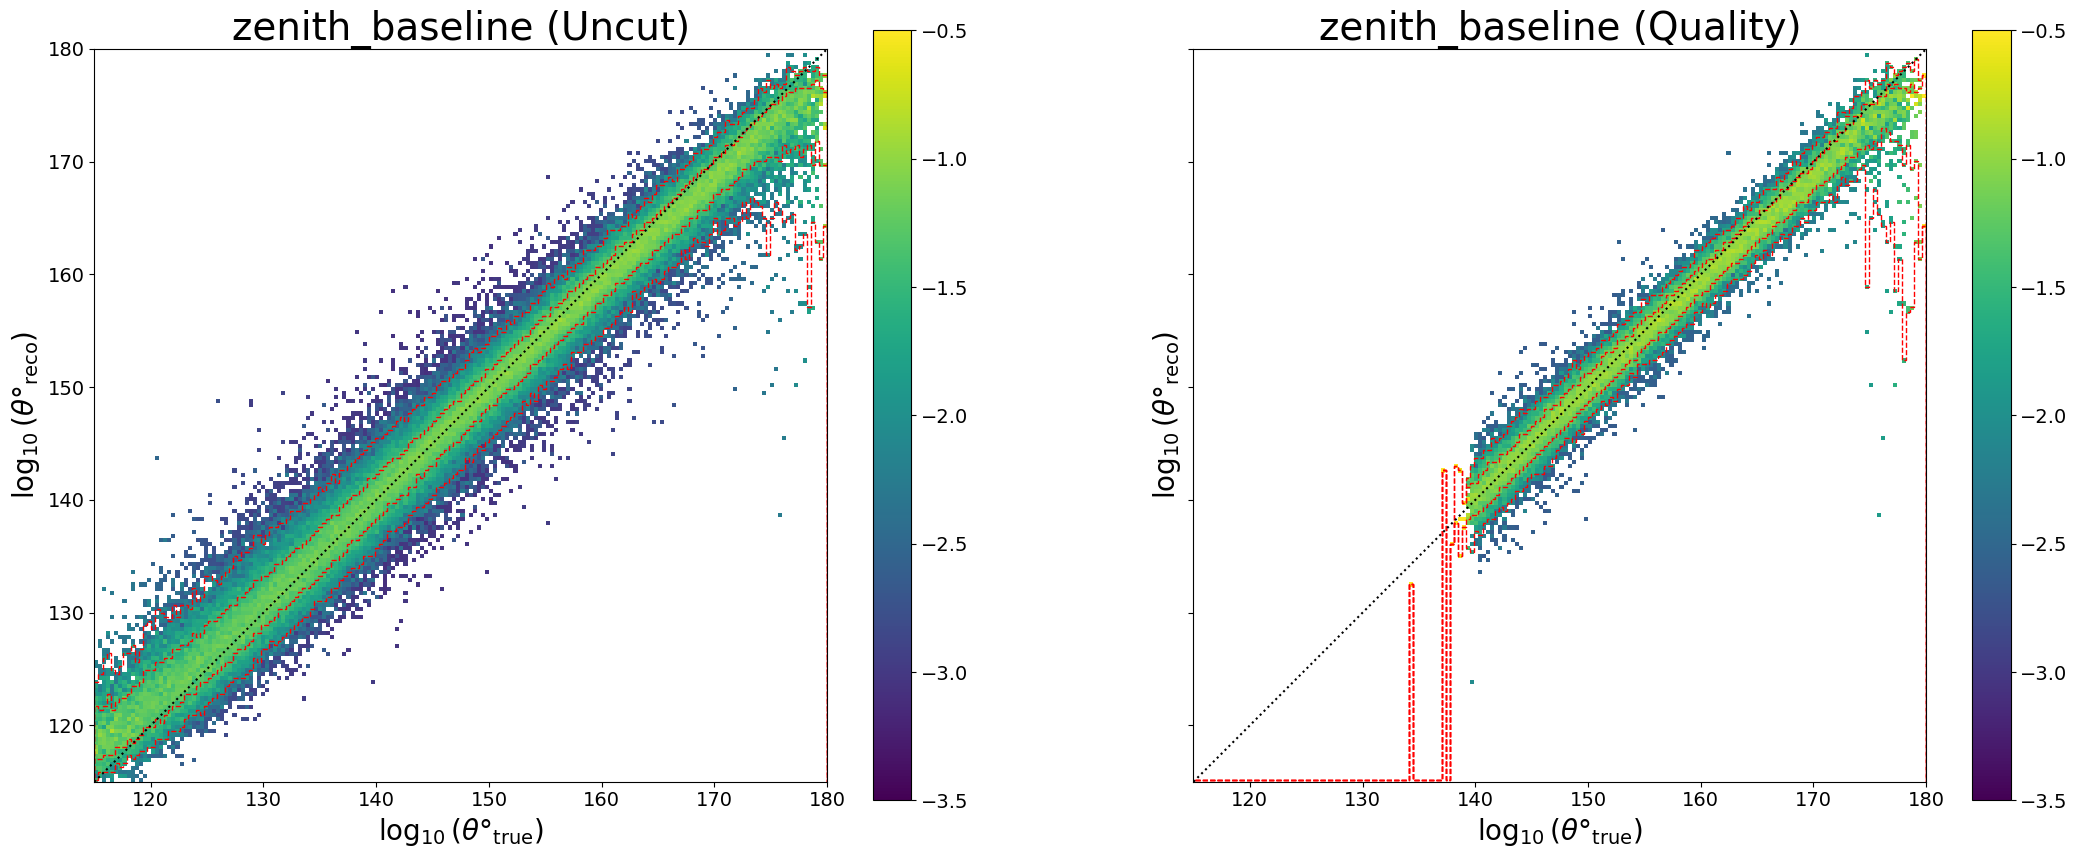

In [11]:
# CONFIG FOR PLOT
cut_names = ['Uncut', 'Quality']
zenith_range = (115, 180)
nbins = 180

# CONFIG FOR TEXT
title_params = {'fontsize':28}
label_params = {'fontsize':20}
tick_params = {'axis':'both', 'direction':'out', 'labelsize':14}

# VARIABLES FOR PLOT
ncols, nrows = len(cut_names), len(model_parameters)
bin_edges = np.linspace(*zenith_range, nbins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(13*ncols, 10*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

# If we are assessing only one model, add an artificial dimension.
if nrows == 1: axs = np.array([axs])
# Loop over the models.
for model_ax, model_name in zip(axs, model_parameters):
    # If we are assessing only one cut, add an artificial dimension.
    if ncols == 1: model_ax = np.array([model_ax])
    # Loop over the cuts.
    for ax, cut_name in zip(model_ax, cut_names):
        
        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)

        # Compute the 2D histogram.
        hist, _, _ = np.histogram2d(180/np.pi*reconstructions[model_name][reconstructions_cut], 180/np.pi*event_parameters['zenith'][events_cut],
                                    bins=(bin_edges, bin_edges))

        # Normalize the histogram along each true zenith bin.
        # This special way of dividing avoids any divide-by-zero errors.
        hist = np.divide(hist, np.sum(hist, axis=0), out=np.zeros_like(hist), where=np.sum(hist, axis=0) != 0)
        
        # Plot the logged 2D histogram.
        # Ignore divide-by-zero errors caused by a value of 0 in any bin.
        with np.errstate(divide='ignore'):
            im = ax.imshow(np.log10(hist), extent=(*zenith_range, *zenith_range), vmin=-3.5, vmax=-0.5, origin='lower')

        # Plot a diagonal line through each plot.
        # This line designates the ideal reconstruction.
        ax.plot(zenith_range, zenith_range, color='black', linestyle=':')

        # Create contour lines for one and two standard deviations on either side of the median.
        # These values are determined for each true energy bin. They definitely need to be determined for each zenith bin.
        contour_values = [.025, .16, .84, .975]
        # Take the cumulative sum of the array, a range [0-1]. We can then look at where we would insert
        #   each contour value to determine the heights for the stairs. For columns with no entries, the
        #   resulting list indices will be past the end of the list. We can use the indices modulo the number
        #   of bins to set the problematic list indices to 0.
        contour_indices = np.asarray([np.searchsorted(col, contour_values) for col in np.cumsum(hist, axis=0).transpose()]) % nbins
        for contour in contour_indices.transpose():
            ax.stairs(bin_centers[contour], edges=bin_edges, color='red', linestyle='--')
        
        # Create a colorbar.
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(**tick_params)
        
        # Set the y-axis limits to be the zenith range.
        ax.set_ylim(zenith_range)

        # Decorate the plot.
        ax.set_title(f'{model_name} ({cut_name})', **title_params)
        ax.set_xlabel(r'$\log_{10}(θ\degree_{\mathrm{true}})$', **label_params)
        ax.set_ylabel(r'$\log_{10}(θ\degree_{\mathrm{reco}})$', **label_params)
        ax.tick_params(**tick_params)

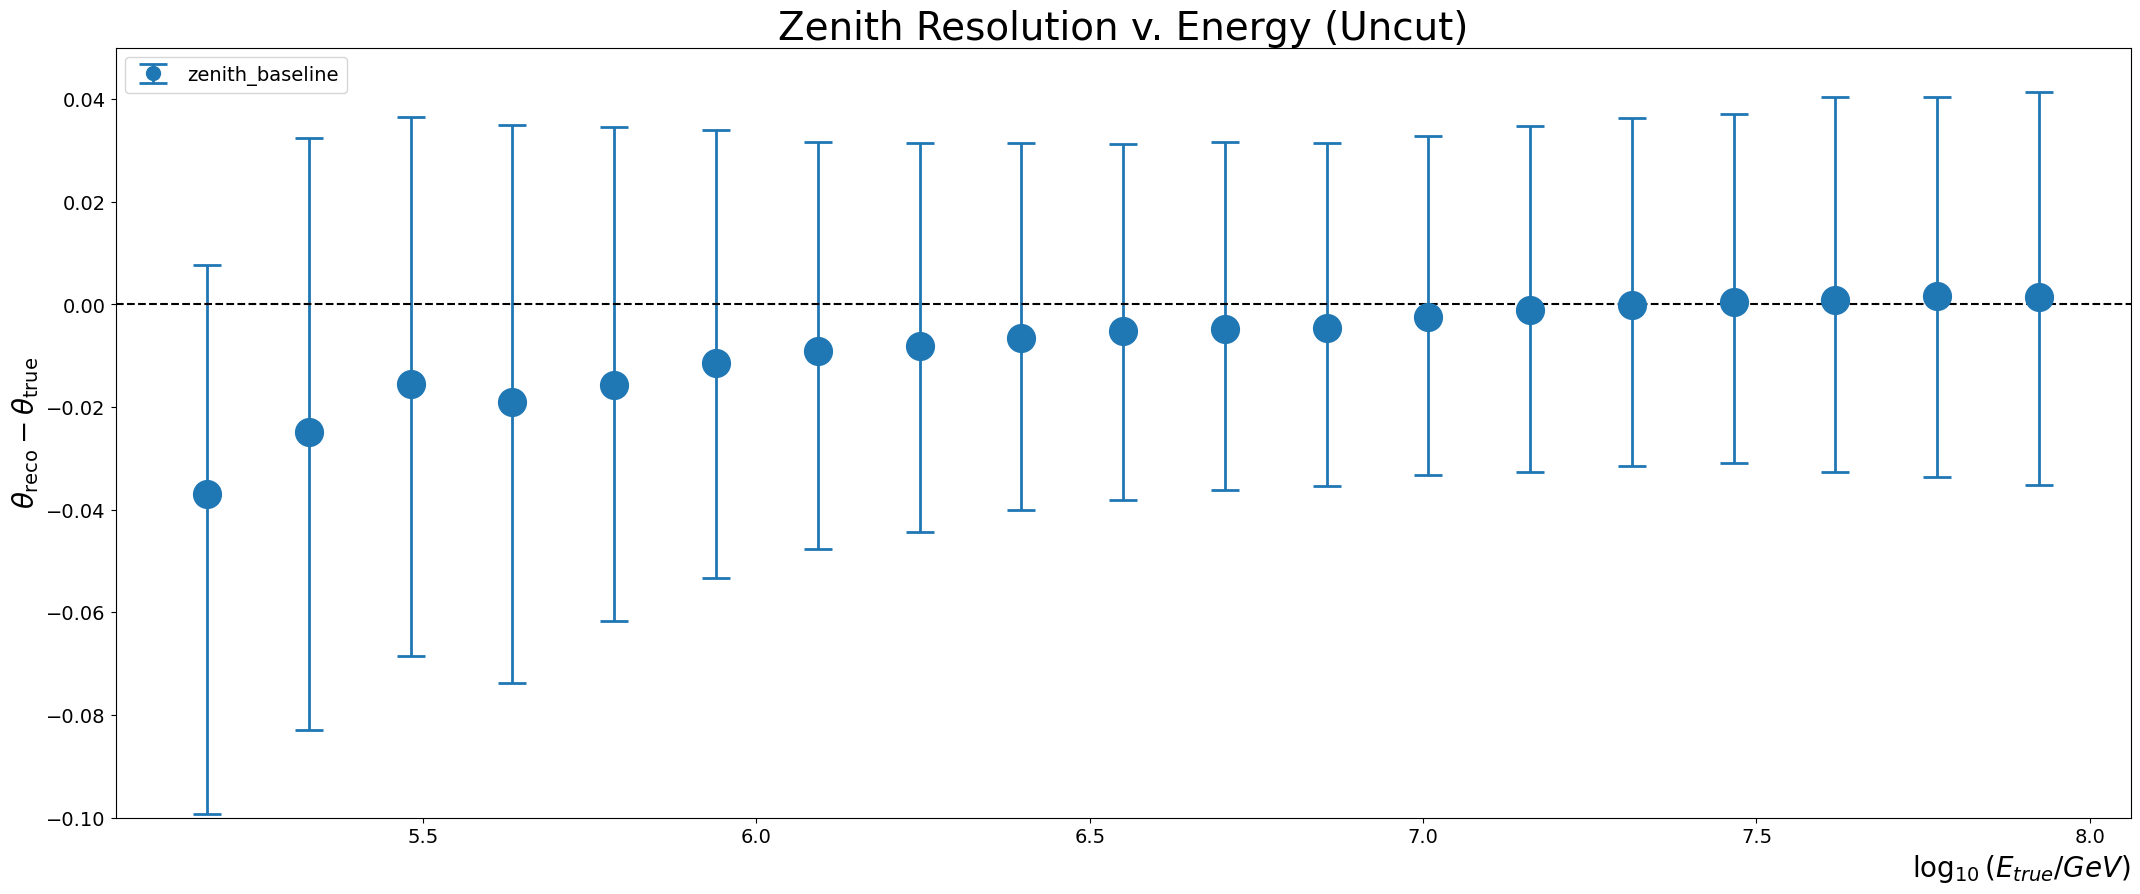

In [12]:
### CONFIG FOR PLOT
cut_names = ['Uncut']
e_range = (5.1, 8)
nbins = 19
comparison_reconstruction = 'laputop'
errorbar_args = {'fmt':'.', 'markersize':40, 'elinewidth':2, 'capsize':10, 'capthick':2}

# CONFIG FOR TEXT
title_params = {'fontsize':28}
label_params = {'fontsize':20}
tick_params = {'labelsize':14}
legend_params = {'fontsize':14, 'markerscale':0.5}

# VARIABLES FOR PLOT
ncols = len(cut_names)
bin_edges = np.linspace(*e_range, nbins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create the plot/subplots.
fig, axs = plt.subplots(figsize=(26, 10), ncols=ncols)

# If we are assessing only one cut, add an artificial dimension.
if ncols == 1: axs = np.array([axs])
# Loop over the cuts.
for ax, cut_name in zip(axs, cut_names):
    # Loop over the models.
    for model_name in model_parameters:
        
        # Get cuts for the model reconstructions and event parameters.
        reconstructions_cut, events_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
    
        # Get the true zenith angle for each event.
        zenith = np.pi - event_parameters[f'{comparison_reconstruction}_dir'][events_cut][..., 0].astype(np.float32)
        # Bin each event by its energy.
        binned_energy = np.digitize(event_parameters['energy'][events_cut], bin_edges)
        # Create an empty array to hold the statistics for each bin.
        binned_statistics = np.zeros((nbins, 3))
        # Loop over the bins.
        for bin in range(nbins):
            # Create a bin-specific cut. This is how we will generate statistics for each bin.
            bin_cut = (binned_energy == bin)
            # No data for a particular bin means we can skip it.
            if not np.any(bin_cut): continue
            # Generate the statistics for each bin.
            binned_statistics[bin] = np.percentile(
                reconstructions[model_name][reconstructions_cut][bin_cut] - event_parameters['zenith'][events_cut][bin_cut],
                (50, 16, 84))
        # Extract each statistic separately.
        median, err_min, err_max = np.transpose(binned_statistics)
        # Plot the zenith resolution as a function of energy.
        ax.errorbar(bin_centers, median, yerr=(median-err_min, err_max-median), label=model_name, **errorbar_args)
    # Plot a horizontal line through the center of each plot.
    # This line designates the ideal reconstruction.
    ax.axhline(color='black', ls='--')
    
    # Set the y-axis limits to be within a reasonable range.
    ax.set_ylim(-0.1, 0.05)
    
    # Decorate the plot.
    ax.set_title(f'Zenith Resolution v. Energy ({cut_name})', **title_params)
    ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$', loc='right', **label_params)
    ax.set_ylabel(r'$θ_{\mathrm{reco}} - θ_{\mathrm{true}}$', **label_params)
    ax.tick_params(**tick_params)
    ax.legend(**legend_params)
